In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import time
import random
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina 
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import PandasTools

from tqdm import tqdm

In [6]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [7]:
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans

In [8]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [5]:
data = pd.read_csv("final_data_added_lipinski.csv")
data.head()

,smiles,zinc_id,MolWt,LogP,HDonors,HAcceptors
0,C[C@H](NC(=O)c1ccc(-c2ccccc2)nc1O)c1ccc(N2CCN(...,2325719276,434.515,3.8361,2,5
1,C[C@@H](NC(=O)/C=C/c1c(Cl)nc2sccn12)c1ccc(N2CC...,2325719436,447.967,3.8307,1,6
2,C[C@H]1CN(c2ccc(CNC(=O)[C@@H](C)n3ccc4ccccc4c3...,252536409,437.515,3.6316,1,5
3,O=C(NCc1ccc(N2CCOCC2)cc1C(F)(F)F)c1ccc(NCC2CC2...,170617918,434.462,3.6889,2,5
4,COc1ccc(Cl)cc1NC(=O)C1=C(C)NC(=S)N[C@@H]1c1ccc...,867170,430.961,3.8461,3,4


In [6]:
data.drop(columns=["smiles", "zinc_id"], inplace=True)
data.head()

,MolWt,LogP,HDonors,HAcceptors
0,434.515,3.8361,2,5
1,447.967,3.8307,1,6
2,437.515,3.6316,1,5
3,434.462,3.6889,2,5
4,430.961,3.8461,3,4


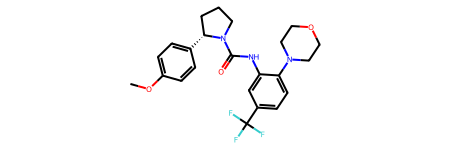

In [7]:
zinc27 = Chem.MolFromSmiles("COc1ccc([C@@H]2CCCN2C(=O)Nc2cc(C(F)(F)F)ccc2N2CCOCC2)cc1")
zinc27

In [8]:
desc_MolWt = Descriptors.MolWt(zinc27)
desc_MolLogP = Descriptors.MolLogP(zinc27)
desc_NumHDonors = Descriptors.NumHDonors(zinc27)
desc_NumHAcceptors = Descriptors.NumHAcceptors(zinc27)

row = np.array([desc_MolWt, desc_MolLogP, desc_NumHDonors, desc_NumHAcceptors])
row

array([449.473 ,   4.9196,   1.    ,   4.    ])

In [9]:
row = pd.DataFrame(row.reshape(1, -1), columns=["MolWt", "LogP", "HDonors", "HAcceptors"])
row

,MolWt,LogP,HDonors,HAcceptors
0,449.473,4.9196,1.0,4.0


In [10]:
final_data = pd.concat([data, row], axis=0)
len(final_data)

10301989

In [11]:
final_data.tail()

,MolWt,LogP,HDonors,HAcceptors
10301984,343.365,-0.8124,1.0,7.0
10301985,329.265,-0.6892,1.0,8.0
10301986,328.350,-0.0430,2.0,6.0
10301987,332.272,-0.0249,1.0,8.0
0,449.473,4.9196,1.0,4.0


In [12]:
final_data = final_data.reset_index(drop=True)
final_data

,MolWt,LogP,HDonors,HAcceptors
0,434.515,3.8361,2.0,5.0
1,447.967,3.8307,1.0,6.0
2,437.515,3.6316,1.0,5.0
3,434.462,3.6889,2.0,5.0
4,430.961,3.8461,3.0,4.0
...,...,...,...,...
10301984,343.365,-0.8124,1.0,7.0
10301985,329.265,-0.6892,1.0,8.0
10301986,328.350,-0.0430,2.0,6.0
10301987,332.272,-0.0249,1.0,8.0


In [13]:
test_data = final_data.drop(columns=["HDonors", "HAcceptors"])
test_data

,MolWt,LogP
0,434.515,3.8361
1,447.967,3.8307
2,437.515,3.6316
3,434.462,3.6889
4,430.961,3.8461
...,...,...
10301984,343.365,-0.8124
10301985,329.265,-0.6892
10301986,328.350,-0.0430
10301987,332.272,-0.0249


In [14]:
noramlized_data = test_data.values
normalized_data = StandardScaler().fit_transform(noramlized_data)

In [15]:
normalized_data.shape

(10301989, 2)

In [16]:
feat_cols = [f"normalized feature {i}" for i in range(normalized_data.shape[1])]

normalized_data = pd.DataFrame(normalized_data, columns=feat_cols)
normalized_data.head()

,normalized feature 0,normalized feature 1
0,1.302078,0.901923
1,1.516242,0.897362
2,1.349840,0.729198
3,1.301234,0.777595
4,1.245496,0.910369


In [17]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

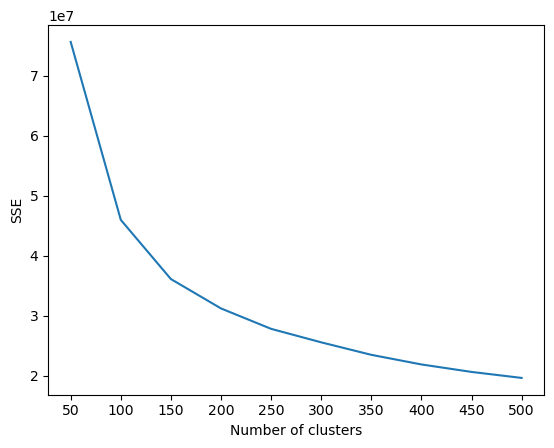

In [18]:
#initialize kmeans parameters

kmeans_kawrgs = {
    "init": "random",
    "n_init": 10,
    "random_state": 42,
}

# create list to hold SSE values for each k
sse = []
for k in (50, 100, 150, 200, 250, 300, 350, 400, 450, 500):
    kmeans = KMeans(n_clusters=k, **kmeans_kawrgs)
    kmeans.fit(data)
    sse.append(kmeans.inertia_)

# visualize results
plt.plot((50, 100, 150, 200, 250, 300, 350, 400, 450, 500), sse)
plt.xticks((50, 100, 150, 200, 250, 300, 350, 400, 450, 500))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

In [19]:
kmeans_kawrgs = {
    "init": "random",
    "n_init": 10,
    "random_state": 42,
}

kmeans = KMeans(n_clusters=150, **kmeans_kawrgs)
kmeans.fit(noramlized_data)
print(kmeans.labels_)

[127   6 146 ... 113  47   6]


In [20]:
len(kmeans.labels_)

10301989

In [21]:
kmeans.labels_ = pd.DataFrame(kmeans.labels_, columns=["cluster"])
kmeans.labels_

,cluster
0,127
1,6
2,146
3,127
4,99
...,...
10301984,81
10301985,113
10301986,113
10301987,47


In [22]:
normalized_data = pd.concat([normalized_data, kmeans.labels_], axis=1)
normalized_data.head()

,normalized feature 0,normalized feature 1,cluster
0,1.302078,0.901923,127
1,1.516242,0.897362,6
2,1.349840,0.729198,146
3,1.301234,0.777595,127
4,1.245496,0.910369,99


In [23]:
from matplotlib.colors import ListedColormap

In [24]:
normalized_data.tail()

,normalized feature 0,normalized feature 1,cluster
10301984,-0.149085,-3.024297,81
10301985,-0.373566,-2.920240,113
10301986,-0.388133,-2.374446,113
10301987,-0.325692,-2.359158,47
10301988,1.540218,1.817070,6


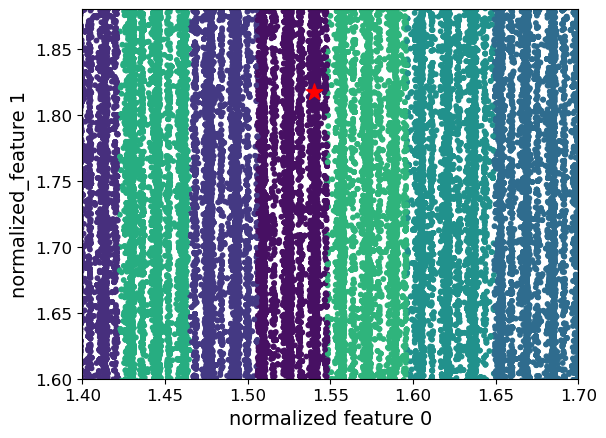

In [25]:
plt.scatter(
    x = normalized_data["normalized feature 0"],
    y = normalized_data["normalized feature 1"],
    c = normalized_data["cluster"],
    s = 10,
)
plt.scatter(
    x = normalized_data["normalized feature 0"][10301988],
    y = normalized_data["normalized feature 1"][10301988],
    marker = "*",
    s=150,
    c="red"
)
plt.xlabel("normalized feature 0", fontsize=14)
plt.ylabel("normalized_feature 1", fontsize=14)
plt.xlim(1.4, 1.7)
plt.ylim(1.6, 1.88)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [27]:
data_1 = pd.read_csv("./data/final_data.csv", low_memory=False)
data_1

,smiles,zinc_id
0,C[C@H](NC(=O)c1ccc(-c2ccccc2)nc1O)c1ccc(N2CCN(...,2325719276
1,C[C@@H](NC(=O)/C=C/c1c(Cl)nc2sccn12)c1ccc(N2CC...,2325719436
2,C[C@H]1CN(c2ccc(CNC(=O)[C@@H](C)n3ccc4ccccc4c3...,252536409
3,O=C(NCc1ccc(N2CCOCC2)cc1C(F)(F)F)c1ccc(NCC2CC2...,170617918
4,COc1ccc(Cl)cc1NC(=O)C1=C(C)NC(=S)N[C@@H]1c1ccc...,867170
...,...,...
10301983,C[C@H]1C(=O)O[C@H]2CC[N+]3([O-])CC=C(COC(=O)[C...,4990630
10301984,CS(=O)(=O)NCC(=O)N1CCN(c2ccc([N+](=O)[O-])nc2)CC1,40556347
10301985,COC(=O)C1=C[C@@]2([N+](=O)[O-])CN(CC(=O)O)C[C@...,100083624
10301986,CN(CC(=O)NC1CC1)c1ccc(S(N)(=O)=O)cc1[N+](=O)[O-],14266733


In [29]:
data_3 = pd.read_csv("./data/clustered_data_by_kmeans.csv", low_memory=False)
data_3

,Unnamed: 0,normalized feature 0,normalized feature 1,normalized feature 2,normalized feature 3,cluster
0,0,1.302078,0.901923,1.076821,0.213286,68
1,1,1.516242,0.897362,-0.109888,0.832435,97
2,2,1.349840,0.729198,-0.109888,0.213286,146
3,3,1.301234,0.777595,1.076821,0.213286,68
4,4,1.245496,0.910369,2.263531,-0.405863,99
...,...,...,...,...,...,...
10301984,10301984,-0.149085,-3.024297,-0.109888,1.451584,81
10301985,10301985,-0.373566,-2.920240,-0.109888,2.070734,113
10301986,10301986,-0.388133,-2.374446,1.076821,0.832435,113
10301987,10301987,-0.325692,-2.359158,-0.109888,2.070734,64


In [33]:
data_3 = data_3.drop(index=10301988, axis=0)
data_3

,Unnamed: 0,normalized feature 0,normalized feature 1,normalized feature 2,normalized feature 3,cluster
0,0,1.302078,0.901923,1.076821,0.213286,68
1,1,1.516242,0.897362,-0.109888,0.832435,97
2,2,1.349840,0.729198,-0.109888,0.213286,146
3,3,1.301234,0.777595,1.076821,0.213286,68
4,4,1.245496,0.910369,2.263531,-0.405863,99
...,...,...,...,...,...,...
10301983,10301983,-0.181006,-2.659083,1.076821,1.451584,81
10301984,10301984,-0.149085,-3.024297,-0.109888,1.451584,81
10301985,10301985,-0.373566,-2.920240,-0.109888,2.070734,113
10301986,10301986,-0.388133,-2.374446,1.076821,0.832435,113


In [34]:
data_1["cluster"] = data_3["cluster"]
data_1

,smiles,zinc_id,cluster
0,C[C@H](NC(=O)c1ccc(-c2ccccc2)nc1O)c1ccc(N2CCN(...,2325719276,68
1,C[C@@H](NC(=O)/C=C/c1c(Cl)nc2sccn12)c1ccc(N2CC...,2325719436,97
2,C[C@H]1CN(c2ccc(CNC(=O)[C@@H](C)n3ccc4ccccc4c3...,252536409,146
3,O=C(NCc1ccc(N2CCOCC2)cc1C(F)(F)F)c1ccc(NCC2CC2...,170617918,68
4,COc1ccc(Cl)cc1NC(=O)C1=C(C)NC(=S)N[C@@H]1c1ccc...,867170,99
...,...,...,...
10301983,C[C@H]1C(=O)O[C@H]2CC[N+]3([O-])CC=C(COC(=O)[C...,4990630,81
10301984,CS(=O)(=O)NCC(=O)N1CCN(c2ccc([N+](=O)[O-])nc2)CC1,40556347,81
10301985,COC(=O)C1=C[C@@]2([N+](=O)[O-])CN(CC(=O)O)C[C@...,100083624,113
10301986,CN(CC(=O)NC1CC1)c1ccc(S(N)(=O)=O)cc1[N+](=O)[O-],14266733,113


In [35]:
cluster_data_with_smiles = data_1[data_1["cluster"] ==6]
cluster_data_with_smiles

,smiles,zinc_id,cluster
116,Cc1ccc([C@@H]2C(C(=O)c3cc(C)ccc3C)=C(O)C(=O)N2...,20167026,6
135,C[C@@H]1CC=C[C@@H]2[C@@H]3O[C@]3(C)[C@H](C)[C@...,2332926187,6
149,COc1ccccc1/C=C1\SC(Nc2ccccc2)=C(C(=O)NC2CCN(C)...,2080317858,6
222,C#CCOc1c(I)cc([C@H]2NC(=O)c3ccccc3O2)cc1OCC,12411410,6
288,C=C(C)CN1C(=O)N[C@@](CC)(C2CCN(C(=O)c3cc(C)nc4...,11782598,6
...,...,...,...
10276474,CCSc1nnc2c(n1)O[C@@H](c1ccc(N(CC)CC)cc1)N(C(C)...,2978132,6
10276477,CCCCSc1nnc2c(n1)O[C@@H](c1ccc(N(C)C)cc1)N(C(C)...,2094218,6
10276478,CCCCSc1nnc2c(n1)O[C@H](c1ccc(N(C)C)cc1)N(C(C)=...,2094216,6
10276479,CCSc1nnc2c(n1)O[C@H](c1ccc(N(CC)CC)cc1)N(C(C)=...,2978133,6


In [36]:
cluster_data_with_smiles = cluster_data_with_smiles.reset_index(drop=True)
cluster_data_with_smiles

,smiles,zinc_id,cluster
0,Cc1ccc([C@@H]2C(C(=O)c3cc(C)ccc3C)=C(O)C(=O)N2...,20167026,6
1,C[C@@H]1CC=C[C@@H]2[C@@H]3O[C@]3(C)[C@H](C)[C@...,2332926187,6
2,COc1ccccc1/C=C1\SC(Nc2ccccc2)=C(C(=O)NC2CCN(C)...,2080317858,6
3,C#CCOc1c(I)cc([C@H]2NC(=O)c3ccccc3O2)cc1OCC,12411410,6
4,C=C(C)CN1C(=O)N[C@@](CC)(C2CCN(C(=O)c3cc(C)nc4...,11782598,6
...,...,...,...
65119,CCSc1nnc2c(n1)O[C@@H](c1ccc(N(CC)CC)cc1)N(C(C)...,2978132,6
65120,CCCCSc1nnc2c(n1)O[C@@H](c1ccc(N(C)C)cc1)N(C(C)...,2094218,6
65121,CCCCSc1nnc2c(n1)O[C@H](c1ccc(N(C)C)cc1)N(C(C)=...,2094216,6
65122,CCSc1nnc2c(n1)O[C@H](c1ccc(N(CC)CC)cc1)N(C(C)=...,2978133,6


In [37]:
cluster_data_with_smiles.to_csv("cluster_data_with_smiles.csv")

# Grupping by tanimoto score

In [15]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import (
    PandasTools,
    Draw,
    Descriptors,
    MACCSkeys,
    rdFingerprintGenerator,
)
from tqdm import tqdm

In [2]:
data = pd.read_csv("./data/added_tanimoto_morgan.csv", usecols=["smiles", "zinc_id", "tanimoto_morgan"], low_memory=False)
data.head()

,smiles,zinc_id,tanimoto_morgan
0,C[C@H](NC(=O)c1ccc(-c2ccccc2)nc1O)c1ccc(N2CCN(...,2325719276,0.348148
1,C[C@@H](NC(=O)/C=C/c1c(Cl)nc2sccn12)c1ccc(N2CC...,2325719436,0.343511
2,C[C@H]1CN(c2ccc(CNC(=O)[C@@H](C)n3ccc4ccccc4c3...,252536409,0.340741
3,O=C(NCc1ccc(N2CCOCC2)cc1C(F)(F)F)c1ccc(NCC2CC2...,170617918,0.479339
4,COc1ccc(Cl)cc1NC(=O)C1=C(C)NC(=S)N[C@@H]1c1ccc...,867170,0.335938


In [3]:
len(data)

10301988

In [6]:
data["tanimoto_morgan"]

0           0.348148
1           0.343511
2           0.340741
3           0.479339
4           0.335938
              ...   
10301983    0.220472
10301984    0.316239
10301985    0.225806
10301986    0.252101
10301987    0.258065
Name: tanimoto_morgan, Length: 10301988, dtype: float64

In [8]:
data.columns

Index(['smiles', 'zinc_id', 'tanimoto_morgan'], dtype='object')

In [16]:
list_a = []
list_b = []
list_c = []
list_d = []
list_e = []
extra_data = []

for i in tqdm(range(len(data)), desc="Processing..."):
    if 0 <= data["tanimoto_morgan"][i] < 0.2:
        list_a.append(data.iloc[i])
    elif 0.2 <= data["tanimoto_morgan"][i] < 0.4:
        list_b.append(data.iloc[i])
    elif 0.4 <= data["tanimoto_morgan"][i] < 0.6:
        list_c.append(data.iloc[i])
    elif 0.6 <= data["tanimoto_morgan"][i] < 0.8:
        list_d.append(data.iloc[i])
    elif 0.8 <= data["tanimoto_morgan"][i] <= 1:
        list_e.append(data.iloc[i])
    else:
        extra_data.append(data.iloc[i])

len(list_a), len(list_b), len(list_c), len(list_d), len(list_e), len(extra_data)


Processing...:   0%|          | 0/10301988 [00:00<?, ?it/s]

Processing...: 100%|██████████| 10301988/10301988 [10:15<00:00, 16733.87it/s]


(770401, 9363462, 167905, 214, 6, 0)

In [9]:
maccs = pd.read_csv("./data/added_tanimoto_maccs.csv", usecols=["smiles", "zinc_id", "tanimoto_maccs"], low_memory=False)
maccs.head()

,smiles,zinc_id,tanimoto_maccs
0,C[C@H](NC(=O)c1ccc(-c2ccccc2)nc1O)c1ccc(N2CCN(...,2325719276,0.635135
1,C[C@@H](NC(=O)/C=C/c1c(Cl)nc2sccn12)c1ccc(N2CC...,2325719436,0.605263
2,C[C@H]1CN(c2ccc(CNC(=O)[C@@H](C)n3ccc4ccccc4c3...,252536409,0.635135
3,O=C(NCc1ccc(N2CCOCC2)cc1C(F)(F)F)c1ccc(NCC2CC2...,170617918,0.704225
4,COc1ccc(Cl)cc1NC(=O)C1=C(C)NC(=S)N[C@@H]1c1ccc...,867170,0.500000


In [10]:
list_1 = []
list_2 = []
list_3 = []
list_4 = []
list_5 = []
extra_data = []

for i in tqdm(range(len(maccs)), desc="Processing..."):
    if 0 <= maccs["tanimoto_maccs"][i] < 0.2:
        list_1.append(maccs.iloc[i])
    elif 0.2 <= maccs["tanimoto_maccs"][i] < 0.4:
        list_2.append(maccs.iloc[i])
    elif 0.4 <= maccs["tanimoto_maccs"][i] < 0.6:
        list_3.append(maccs.iloc[i])
    elif 0.6 <= maccs["tanimoto_maccs"][i] < 0.8:
        list_4.append(maccs.iloc[i])
    elif 0.8 <= maccs["tanimoto_maccs"][i] <= 1:
        list_5.append(maccs.iloc[i])
    else:
        extra_data.append(maccs.iloc[i])

len(list_1), len(list_2), len(list_3), len(list_4), len(list_5), len(extra_data)

Processing...: 100%|██████████| 10301988/10301988 [10:59<00:00, 15611.02it/s]


(49992, 1823035, 6643906, 1779896, 5159, 0)

In [11]:
from tqdm import tqdm

In [16]:
list_5 = pd.DataFrame(list_5)

In [17]:
list_5

,smiles,zinc_id,tanimoto_maccs
10129,COCCOc1ccc(C(F)(F)F)cc1NC(=O)C1CCN(c2ccc(C#N)c...,24715307,0.802817
15659,C#CCOc1ccc(CCNC(=O)Nc2cc(C(F)(F)F)ccc2N2CCOCC2...,72278478,0.852941
19447,O=C(COc1ccc(NC(=O)C2(c3ccccc3F)CCOCC2)cc1)N1CCCC1,225570998,0.811594
19575,COc1ccc(C(=O)Nc2cc(C(F)(F)F)ccc2N2CCOCC2)c(OC)...,12608018,0.826087
20189,COc1cccc(NC(=O)N2CC[C@@H]3CN(c4ccc(C(F)(F)F)cn...,1889197941,0.842857
...,...,...,...
10256723,COc1ccc2c(C)c(C(=O)N[C@@H]3CCCN(c4ccc(C(F)(F)F...,19720357,0.830986
10257318,COc1ccc(NC(=O)N2CCC[C@H](C(=O)c3cccc(C(F)(F)F)...,12458796,0.805970
10258785,Cc1ccc(C(C)C)c(OCC(=O)Nc2cc(C(F)(F)F)ccc2N2CCO...,1144533,0.811594
10292228,COc1ncc(Cl)c(N2CCN([C@@]3(C(N)=O)CCOC3)CC2)n1,886094629,0.819444


In [35]:
list_5 = list_5.reset_index(drop=True)
list_5

,smiles,zinc_id,tanimoto_maccs
0,COCCOc1ccc(C(F)(F)F)cc1NC(=O)C1CCN(c2ccc(C#N)c...,24715307,0.802817
1,C#CCOc1ccc(CCNC(=O)Nc2cc(C(F)(F)F)ccc2N2CCOCC2...,72278478,0.852941
2,O=C(COc1ccc(NC(=O)C2(c3ccccc3F)CCOCC2)cc1)N1CCCC1,225570998,0.811594
3,COc1ccc(C(=O)Nc2cc(C(F)(F)F)ccc2N2CCOCC2)c(OC)...,12608018,0.826087
4,COc1cccc(NC(=O)N2CC[C@@H]3CN(c4ccc(C(F)(F)F)cn...,1889197941,0.842857
...,...,...,...
5154,COc1ccc2c(C)c(C(=O)N[C@@H]3CCCN(c4ccc(C(F)(F)F...,19720357,0.830986
5155,COc1ccc(NC(=O)N2CCC[C@H](C(=O)c3cccc(C(F)(F)F)...,12458796,0.805970
5156,Cc1ccc(C(C)C)c(OCC(=O)Nc2cc(C(F)(F)F)ccc2N2CCO...,1144533,0.811594
5157,COc1ncc(Cl)c(N2CCN([C@@]3(C(N)=O)CCOC3)CC2)n1,886094629,0.819444


In [36]:
list__ = []

for i in range(len(list_5)):
    if list_5["tanimoto_maccs"][i] >= 8.5:
        list__.append(list_5.iloc[i])

list__ = pd.DataFrame(list__)
print(len(list__))
list__.head()

0


""


# Ligand's features by RDKit

In [23]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from tqdm import tqdm 
import pandas as pd
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.rdMolDescriptors import CalcNumRotatableBonds

In [37]:
test = pd.read_csv("./data/lipinski_data.csv", usecols=["smiles", "zinc_id", "MolWt", "LogP", "HDonors", "HAcceptors"], low_memory=False)
test = test[:10]
test.head()

,smiles,zinc_id,MolWt,LogP,HDonors,HAcceptors
0,CN(Cc1ccon1)C(=O)[C@@H]1C[C@@H](Sc2ccc(F)cc2)C...,12040347,441.528,3.91310,1,6
1,COc1ccc(O)c(CN2CCC(Oc3ccc(C(=O)NCc4ccccn4)cc3)...,12434673,447.535,3.76920,2,6
2,Cc1ccc([C@@H]2OC3(C(=O)c4ccccc4C3=O)[C@H]3C(=O...,101102011,443.499,3.81822,0,5
3,CC(C)N1C(=O)/C(=C2/C(=O)N(CC(=O)Nc3ccccc3)c3cc...,1742077,437.546,3.65170,1,5
4,CS(=O)(=O)Nc1ccccc1[C@@H]1CC(c2ccccc2O)=NN1C(=...,252481051,435.505,3.75520,2,5


In [38]:
rotatable_bonds = []

for i in range(len(test)):
    mol = Chem.MolFromSmiles(test["smiles"][i])
    Rotatable_Bonds = Chem.rdMolDescriptors.CalcNumRotatableBonds(mol)
    rotatable_bonds.append(Rotatable_Bonds)

rotatable_bonds = pd.Series(rotatable_bonds).T
rotatable_bonds = rotatable_bonds.rename("rotatable_bonds")


test = pd.concat([test, rotatable_bonds], axis=1)
test.head()

,smiles,zinc_id,MolWt,LogP,HDonors,HAcceptors,rotatable_bonds
0,CN(Cc1ccon1)C(=O)[C@@H]1C[C@@H](Sc2ccc(F)cc2)C...,12040347,441.528,3.91310,1,6,7
1,COc1ccc(O)c(CN2CCC(Oc3ccc(C(=O)NCc4ccccn4)cc3)...,12434673,447.535,3.76920,2,6,8
2,Cc1ccc([C@@H]2OC3(C(=O)c4ccccc4C3=O)[C@H]3C(=O...,101102011,443.499,3.81822,0,5,2
3,CC(C)N1C(=O)/C(=C2/C(=O)N(CC(=O)Nc3ccccc3)c3cc...,1742077,437.546,3.65170,1,5,4
4,CS(=O)(=O)Nc1ccccc1[C@@H]1CC(c2ccccc2O)=NN1C(=...,252481051,435.505,3.75520,2,5,5


In [39]:
aromatic_rings = []

for i in range(len(test)):
    mol = Chem.MolFromSmiles(test["smiles"][i])
    Aromatic_Rings = Chem.rdMolDescriptors.CalcNumAromaticRings(mol)
    aromatic_rings.append(Aromatic_Rings)

aromatic_rings = pd.Series(aromatic_rings).T
aromatic_rings = aromatic_rings.rename("aromatic_rings")


test = pd.concat([test, aromatic_rings], axis=1)
test.head()

,smiles,zinc_id,MolWt,LogP,HDonors,HAcceptors,rotatable_bonds,aromatic_rings
0,CN(Cc1ccon1)C(=O)[C@@H]1C[C@@H](Sc2ccc(F)cc2)C...,12040347,441.528,3.91310,1,6,7,3
1,COc1ccc(O)c(CN2CCC(Oc3ccc(C(=O)NCc4ccccn4)cc3)...,12434673,447.535,3.76920,2,6,8,3
2,Cc1ccc([C@@H]2OC3(C(=O)c4ccccc4C3=O)[C@H]3C(=O...,101102011,443.499,3.81822,0,5,2,2
3,CC(C)N1C(=O)/C(=C2/C(=O)N(CC(=O)Nc3ccccc3)c3cc...,1742077,437.546,3.65170,1,5,4,2
4,CS(=O)(=O)Nc1ccccc1[C@@H]1CC(c2ccccc2O)=NN1C(=...,252481051,435.505,3.75520,2,5,5,3


In [40]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [42]:
test.drop(columns=["smiles", "zinc_id"], inplace=True)

In [43]:
noramlized_data = test.values
normalized_data = StandardScaler().fit_transform(noramlized_data)

In [44]:
feat_cols = [f"normalized feature {i}" for i in range(normalized_data.shape[1])]

normalized_data = pd.DataFrame(normalized_data, columns=feat_cols)
normalized_data.head()

,normalized feature 0,normalized feature 1,normalized feature 2,normalized feature 3,normalized feature 4,normalized feature 5
0,0.630403,1.312749,-0.48795,0.204124,1.293993,1.0
1,1.522829,0.107401,0.48795,0.204124,1.833157,1.0
2,0.923223,0.518006,-1.46385,-0.816497,-1.401826,-1.0
3,0.038820,-0.876813,-0.48795,-0.816497,-0.323498,-1.0
4,-0.264400,-0.009867,0.48795,-0.816497,0.215666,1.0


In [45]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(normalized_data)
principalDf = pd.DataFrame(data=principalComponents, columns=["principal component 1", "principal component 2"])

In [47]:
principalDf.head()

,principal component 1,principal component 2
0,-1.553760,-0.186199
1,-2.193949,-0.967448
2,1.391492,-0.781830
3,1.263318,-0.984860
4,-0.792425,-0.280616


In [48]:
pca.explained_variance_ratio_

array([0.38424367, 0.28102969])

In [49]:
sum(pca.explained_variance_ratio_)

0.6652733667395943

In [53]:
pca = PCA(n_components=3)

printcipalComponents = pca.fit_transform(normalized_data)

principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2', '3'])

print(pca.explained_variance_ratio_)

print(sum(pca.explained_variance_ratio_))

[0.38424367 0.28102969 0.12950659]
0.7947799529893723


In [54]:
test_2 = test[["LogP", "HDonors", "HAcceptors", "rotatable_bonds", "aromatic_rings"]]

In [55]:
test_2.head()

,LogP,HDonors,HAcceptors,rotatable_bonds,aromatic_rings
0,3.91310,1,6,7,3
1,3.76920,2,6,8,3
2,3.81822,0,5,2,2
3,3.65170,1,5,4,2
4,3.75520,2,5,5,3


In [57]:
noramlized_data = test_2.values
normalized_data = StandardScaler().fit_transform(noramlized_data)

In [58]:
feat_cols = [f"normalized feature {i}" for i in range(normalized_data.shape[1])]

normalized_data = pd.DataFrame(normalized_data, columns=feat_cols)
normalized_data.head()

,normalized feature 0,normalized feature 1,normalized feature 2,normalized feature 3,normalized feature 4
0,1.312749,-0.48795,0.204124,1.293993,1.0
1,0.107401,0.48795,0.204124,1.833157,1.0
2,0.518006,-1.46385,-0.816497,-1.401826,-1.0
3,-0.876813,-0.48795,-0.816497,-0.323498,-1.0
4,-0.009867,0.48795,-0.816497,0.215666,1.0


In [59]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(normalized_data)
principalDf = pd.DataFrame(data=principalComponents, columns=["principal component 1", "principal component 2"])

In [60]:
print(pca.explained_variance_ratio_)

print(sum(pca.explained_variance_ratio_))

[0.42853595 0.26768495]
0.6962209006831384


In [61]:
test = pd.read_csv("./data/lipinski_data.csv", usecols=["smiles", "zinc_id", "MolWt", "LogP", "HDonors", "HAcceptors"], low_memory=False)
test.head()

,smiles,zinc_id,MolWt,LogP,HDonors,HAcceptors
0,CN(Cc1ccon1)C(=O)[C@@H]1C[C@@H](Sc2ccc(F)cc2)C...,12040347,441.528,3.91310,1,6
1,COc1ccc(O)c(CN2CCC(Oc3ccc(C(=O)NCc4ccccn4)cc3)...,12434673,447.535,3.76920,2,6
2,Cc1ccc([C@@H]2OC3(C(=O)c4ccccc4C3=O)[C@H]3C(=O...,101102011,443.499,3.81822,0,5
3,CC(C)N1C(=O)/C(=C2/C(=O)N(CC(=O)Nc3ccccc3)c3cc...,1742077,437.546,3.65170,1,5
4,CS(=O)(=O)Nc1ccccc1[C@@H]1CC(c2ccccc2O)=NN1C(=...,252481051,435.505,3.75520,2,5


In [62]:
rotatable_bonds = []

for i in range(len(test)):
    mol = Chem.MolFromSmiles(test["smiles"][i])
    Rotatable_Bonds = Chem.rdMolDescriptors.CalcNumRotatableBonds(mol)
    rotatable_bonds.append(Rotatable_Bonds)

rotatable_bonds = pd.Series(rotatable_bonds).T
rotatable_bonds = rotatable_bonds.rename("rotatable_bonds")


test = pd.concat([test, rotatable_bonds], axis=1)
test.head()

,smiles,zinc_id,MolWt,LogP,HDonors,HAcceptors,rotatable_bonds
0,CN(Cc1ccon1)C(=O)[C@@H]1C[C@@H](Sc2ccc(F)cc2)C...,12040347,441.528,3.91310,1,6,7
1,COc1ccc(O)c(CN2CCC(Oc3ccc(C(=O)NCc4ccccn4)cc3)...,12434673,447.535,3.76920,2,6,8
2,Cc1ccc([C@@H]2OC3(C(=O)c4ccccc4C3=O)[C@H]3C(=O...,101102011,443.499,3.81822,0,5,2
3,CC(C)N1C(=O)/C(=C2/C(=O)N(CC(=O)Nc3ccccc3)c3cc...,1742077,437.546,3.65170,1,5,4
4,CS(=O)(=O)Nc1ccccc1[C@@H]1CC(c2ccccc2O)=NN1C(=...,252481051,435.505,3.75520,2,5,5


In [63]:
aromatic_rings = []

for i in range(len(test)):
    mol = Chem.MolFromSmiles(test["smiles"][i])
    Aromatic_Rings = Chem.rdMolDescriptors.CalcNumAromaticRings(mol)
    aromatic_rings.append(Aromatic_Rings)

aromatic_rings = pd.Series(aromatic_rings).T
aromatic_rings = aromatic_rings.rename("aromatic_rings")


test = pd.concat([test, aromatic_rings], axis=1)
test.head()

,smiles,zinc_id,MolWt,LogP,HDonors,HAcceptors,rotatable_bonds,aromatic_rings
0,CN(Cc1ccon1)C(=O)[C@@H]1C[C@@H](Sc2ccc(F)cc2)C...,12040347,441.528,3.91310,1,6,7,3
1,COc1ccc(O)c(CN2CCC(Oc3ccc(C(=O)NCc4ccccn4)cc3)...,12434673,447.535,3.76920,2,6,8,3
2,Cc1ccc([C@@H]2OC3(C(=O)c4ccccc4C3=O)[C@H]3C(=O...,101102011,443.499,3.81822,0,5,2,2
3,CC(C)N1C(=O)/C(=C2/C(=O)N(CC(=O)Nc3ccccc3)c3cc...,1742077,437.546,3.65170,1,5,4,2
4,CS(=O)(=O)Nc1ccccc1[C@@H]1CC(c2ccccc2O)=NN1C(=...,252481051,435.505,3.75520,2,5,5,3


In [64]:
test.drop(columns=["smiles", "zinc_id"], inplace=True)

In [65]:
noramlized_data = test.values
normalized_data = StandardScaler().fit_transform(noramlized_data)

In [69]:
feat_cols = [f"normalized feature {i}" for i in range(normalized_data.shape[1])]

normalized_data = pd.DataFrame(normalized_data, columns=feat_cols)
normalized_data.head()

,normalized feature 0,normalized feature 1,normalized feature 2,normalized feature 3,normalized feature 4,normalized feature 5
0,1.389781,0.946954,-0.115785,0.826105,1.099009,1.039461
1,1.484910,0.825571,1.066928,0.826105,1.603304,1.039461
2,1.420994,0.866920,-1.298499,0.206874,-1.422469,-0.038060
3,1.326721,0.726457,-0.115785,0.206874,-0.413878,-0.038060
4,1.294399,0.813761,1.066928,0.206874,0.090418,1.039461


In [71]:
pca = PCA(n_components=2)

printcipalComponents = pca.fit_transform(normalized_data)

principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])

print(pca.explained_variance_ratio_)

print(sum(pca.explained_variance_ratio_))

[0.38089948 0.21662052]
0.5975200011232453


In [72]:
pca = PCA(n_components=3)

printcipalComponents = pca.fit_transform(normalized_data)

principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2', '3'])

print(pca.explained_variance_ratio_)

print(sum(pca.explained_variance_ratio_))

[0.38089948 0.21662052 0.17341576]
0.7709357649576333


# Check the parsed Data with tanimoto similarity

In [2]:
import pandas as pd

In [6]:
data = pd.read_csv("./docking_data/parsed_docking_data_tanimoto_similarity/merged_docking_data_based_tanimoto_similarity.csv", low_memory=False)
data["0"]

0      -8.6
1      -9.6
2      -8.5
3      -7.9
4      -6.6
       ... 
5154   -6.7
5155   -7.9
5156   -7.9
5157   -8.2
5158   -7.5
Name: 0, Length: 5159, dtype: float64

# Check the lipinski data after docking and merge

In [1]:
import pandas as pd

In [2]:
docking_data = pd.read_csv("merged_docking_data_based_lipinski_features.csv", low_memory=False,)
docking_data.head()

,0
0,-7.5
1,-8.4
2,-8.0
3,-7.1
4,-9.1


In [3]:
docking_data.rename(columns={"0":"docking_score"}, inplace=True)
docking_data.head()
print(len(docking_data))

65124


In [4]:
data = pd.read_csv("final_data_with_cluster_6.csv", low_memory=False,)
data = data[:65124]
print(len(data))

65124


In [5]:
data.head()

,Unnamed: 0,MolWt,LogP,HDonors,HAcceptors,cluster
0,0,448.563,3.91246,1.0,5.0,6
1,1,449.591,3.71220,1.0,4.0,6
2,2,449.576,3.88610,2.0,6.0,6
3,3,449.244,3.52290,1.0,4.0,6
4,4,448.567,3.98054,1.0,4.0,6


In [6]:
merged_data = pd.concat([data, docking_data], axis=1)
merged_data.head()

,Unnamed: 0,MolWt,LogP,HDonors,HAcceptors,cluster,docking_score
0,0,448.563,3.91246,1.0,5.0,6,-7.5
1,1,449.591,3.71220,1.0,4.0,6,-8.4
2,2,449.576,3.88610,2.0,6.0,6,-8.0
3,3,449.244,3.52290,1.0,4.0,6,-7.1
4,4,448.567,3.98054,1.0,4.0,6,-9.1


In [7]:
merged_data.tail()

,Unnamed: 0,MolWt,LogP,HDonors,HAcceptors,cluster,docking_score
65119,65119,449.58,4.9409,0.0,7.0,6,-6.1
65120,65120,449.58,4.9409,0.0,7.0,6,-6.3
65121,65121,449.58,4.9409,0.0,7.0,6,-7.2
65122,65122,449.58,4.9409,0.0,7.0,6,-6.9
65123,65123,449.58,4.9409,0.0,7.0,6,-7.3


In [8]:
data_2 = pd.read_csv("cluster_data_with_smiles.csv",usecols=["smiles", "zinc_id"], low_memory=False)
data_2.head()

,smiles,zinc_id
0,Cc1ccc([C@@H]2C(C(=O)c3cc(C)ccc3C)=C(O)C(=O)N2...,20167026
1,C[C@@H]1CC=C[C@@H]2[C@@H]3O[C@]3(C)[C@H](C)[C@...,2332926187
2,COc1ccccc1/C=C1\SC(Nc2ccccc2)=C(C(=O)NC2CCN(C)...,2080317858
3,C#CCOc1c(I)cc([C@H]2NC(=O)c3ccccc3O2)cc1OCC,12411410
4,C=C(C)CN1C(=O)N[C@@](CC)(C2CCN(C(=O)c3cc(C)nc4...,11782598


In [11]:
final_merged_data = pd.concat([data_2, merged_data], axis=1)
final_merged_data.head()

,smiles,zinc_id,Unnamed: 0,MolWt,LogP,HDonors,HAcceptors,cluster,docking_score
0,Cc1ccc([C@@H]2C(C(=O)c3cc(C)ccc3C)=C(O)C(=O)N2...,20167026,0,448.563,3.91246,1.0,5.0,6,-7.5
1,C[C@@H]1CC=C[C@@H]2[C@@H]3O[C@]3(C)[C@H](C)[C@...,2332926187,1,449.591,3.71220,1.0,4.0,6,-8.4
2,COc1ccccc1/C=C1\SC(Nc2ccccc2)=C(C(=O)NC2CCN(C)...,2080317858,2,449.576,3.88610,2.0,6.0,6,-8.0
3,C#CCOc1c(I)cc([C@H]2NC(=O)c3ccccc3O2)cc1OCC,12411410,3,449.244,3.52290,1.0,4.0,6,-7.1
4,C=C(C)CN1C(=O)N[C@@](CC)(C2CCN(C(=O)c3cc(C)nc4...,11782598,4,448.567,3.98054,1.0,4.0,6,-9.1


In [12]:
final_merged_data.tail()

,smiles,zinc_id,Unnamed: 0,MolWt,LogP,HDonors,HAcceptors,cluster,docking_score
65119,CCSc1nnc2c(n1)O[C@@H](c1ccc(N(CC)CC)cc1)N(C(C)...,2978132,65119,449.58,4.9409,0.0,7.0,6,-6.1
65120,CCCCSc1nnc2c(n1)O[C@@H](c1ccc(N(C)C)cc1)N(C(C)...,2094218,65120,449.58,4.9409,0.0,7.0,6,-6.3
65121,CCCCSc1nnc2c(n1)O[C@H](c1ccc(N(C)C)cc1)N(C(C)=...,2094216,65121,449.58,4.9409,0.0,7.0,6,-7.2
65122,CCSc1nnc2c(n1)O[C@H](c1ccc(N(CC)CC)cc1)N(C(C)=...,2978133,65122,449.58,4.9409,0.0,7.0,6,-6.9
65123,CCC(=O)N1c2ccccc2-c2nnc(SC)nc2O[C@H]1c1ccc(N(C...,8453039,65123,449.58,4.9409,0.0,7.0,6,-7.3


In [13]:
final_merged_data.drop(columns=["Unnamed: 0"], inplace=True)
final_merged_data.head()

,smiles,zinc_id,MolWt,LogP,HDonors,HAcceptors,cluster,docking_score
0,Cc1ccc([C@@H]2C(C(=O)c3cc(C)ccc3C)=C(O)C(=O)N2...,20167026,448.563,3.91246,1.0,5.0,6,-7.5
1,C[C@@H]1CC=C[C@@H]2[C@@H]3O[C@]3(C)[C@H](C)[C@...,2332926187,449.591,3.71220,1.0,4.0,6,-8.4
2,COc1ccccc1/C=C1\SC(Nc2ccccc2)=C(C(=O)NC2CCN(C)...,2080317858,449.576,3.88610,2.0,6.0,6,-8.0
3,C#CCOc1c(I)cc([C@H]2NC(=O)c3ccccc3O2)cc1OCC,12411410,449.244,3.52290,1.0,4.0,6,-7.1
4,C=C(C)CN1C(=O)N[C@@](CC)(C2CCN(C(=O)c3cc(C)nc4...,11782598,448.567,3.98054,1.0,4.0,6,-9.1


In [14]:
final_merged_data.to_csv("final_merged_docking_data_with_lipinski_feature_data.csv")

# Merge tanimoto data

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("merged_docking_data_based_tanimoto_similarity.csv", low_memory=False)
print(len(data))

5159


In [3]:
data_2 = pd.read_csv("similarity_with_zn27_by_tanimoto_maccs.csv", low_memory=False)
print(len(data_2))

5159


In [4]:
merge_data = pd.concat([data_2, data], axis=1)
merge_data.head()

,smiles,zinc_id,tanimoto_maccs,0
0,COCCOc1ccc(C(F)(F)F)cc1NC(=O)C1CCN(c2ccc(C#N)c...,24715307,0.802817,-8.6
1,C#CCOc1ccc(CCNC(=O)Nc2cc(C(F)(F)F)ccc2N2CCOCC2...,72278478,0.852941,-9.6
2,O=C(COc1ccc(NC(=O)C2(c3ccccc3F)CCOCC2)cc1)N1CCCC1,225570998,0.811594,-8.5
3,COc1ccc(C(=O)Nc2cc(C(F)(F)F)ccc2N2CCOCC2)c(OC)...,12608018,0.826087,-7.9
4,COc1cccc(NC(=O)N2CC[C@@H]3CN(c4ccc(C(F)(F)F)cn...,1889197941,0.842857,-6.6


In [5]:
merge_data.rename(columns={"tanimoto_maccs":"tanimoto_similarity"}, inplace=True)
merge_data.head()

,smiles,zinc_id,tanimoto_similarity,0
0,COCCOc1ccc(C(F)(F)F)cc1NC(=O)C1CCN(c2ccc(C#N)c...,24715307,0.802817,-8.6
1,C#CCOc1ccc(CCNC(=O)Nc2cc(C(F)(F)F)ccc2N2CCOCC2...,72278478,0.852941,-9.6
2,O=C(COc1ccc(NC(=O)C2(c3ccccc3F)CCOCC2)cc1)N1CCCC1,225570998,0.811594,-8.5
3,COc1ccc(C(=O)Nc2cc(C(F)(F)F)ccc2N2CCOCC2)c(OC)...,12608018,0.826087,-7.9
4,COc1cccc(NC(=O)N2CC[C@@H]3CN(c4ccc(C(F)(F)F)cn...,1889197941,0.842857,-6.6


In [6]:
merge_data.rename(columns={"0":"docking_score"}, inplace=True)
merge_data.head()

,smiles,zinc_id,tanimoto_similarity,docking_score
0,COCCOc1ccc(C(F)(F)F)cc1NC(=O)C1CCN(c2ccc(C#N)c...,24715307,0.802817,-8.6
1,C#CCOc1ccc(CCNC(=O)Nc2cc(C(F)(F)F)ccc2N2CCOCC2...,72278478,0.852941,-9.6
2,O=C(COc1ccc(NC(=O)C2(c3ccccc3F)CCOCC2)cc1)N1CCCC1,225570998,0.811594,-8.5
3,COc1ccc(C(=O)Nc2cc(C(F)(F)F)ccc2N2CCOCC2)c(OC)...,12608018,0.826087,-7.9
4,COc1cccc(NC(=O)N2CC[C@@H]3CN(c4ccc(C(F)(F)F)cn...,1889197941,0.842857,-6.6


In [7]:
merge_data.to_csv("final_merged_docking_data_with_tanimoto_similarity.csv")